# Binary Signal Recovery Using the Metropolis-Hastings Algorithm

## Introduction

This project aims to recover a binary signal $( \theta )$ from noisy observations $( y )$ using Markov Chain Monte Carlo (MCMC) techniques, specifically the Metropolis-Hastings algorithm. We want to explore how the mean squared error (MSE) varies with the number of measurements $( m )$ and the number of independent realizations $( M )$.

## Problem Definition

### Signal Model

The problem is formulated as follows:

- Let $( X \in \mathbb{R}^{m \times d} )$ be a measurement matrix with i.i.d. entries sampled from $( N(0, 1) )$.
- Let $( \xi \in \mathbb{R}^m )$ be a noise vector independent of $( X )$ with i.i.d. entries sampled from $( N(0, 1) )$.
- Let $( \theta \in \{0, 1\}^d )$ be a binary signal chosen uniformly at random and independent of the pair $( (X, \xi) )$.

The observation vector $( y )$ is generated as:

$[ y = X\theta + \xi ]$

The goal is to recover the unknown vector $( \theta )$ using the observations $( (X, y) )$, using the Metropolis-Hastings to find the value of the vector that minimizes $\mathcal{H}(X, y; \theta)$

In [97]:
import numpy as np
import matplotlib.pyplot as plt

In [98]:
def generate_data(m, d):
    X = np.random.normal(0, 1, (m, d))  # Genera la matrice X con distribuzione normale standard
    theta = np.random.choice([0, 1], d)  # Genera il vettore del segnale theta con valori binari
    xi = np.random.normal(0, 1, m)  # Genera il vettore del rumore xi
    y = X @ theta + xi  # Calcola il vettore delle misurazioni y
    return X, y, theta

$$ 𝑦 = 𝑋𝜃 + 𝜉 $$

## Maximum Likelihood Estimation

The maximum likelihood estimate $( \hat{\theta} )$ is given by the value of $( \theta )$ that maximizes the likelihood function:

$\mathcal{L}(X, y; \theta) = \frac{\exp \left\{-\frac{1}{2} (y - X\theta)^T (y - X\theta)\right\}}{(2\pi)^{m/2}}$

which is equivalent to minimizing the function:

$\mathcal{H}(X, y; \theta) = (y - X\theta)^T (y - X\theta)$

In [99]:
def H(X, y, theta):
    return (y - X @ theta).T @ (y - X @ theta) # Norma al quadrato della differenza tra y e Xθ

## Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is used to find the estimate $ \hat{\theta} $. The stationary distribution $ \pi_{\beta}(\theta) $ is defined as:

$ \pi_{\beta}(\theta) = \frac{e^{-\beta H(X;y;\theta)}}{Z_{\beta}}, \quad \text{with} \quad Z_{\beta} = \sum_{\theta \in \Theta} e^{-\beta H(X;y;\theta)}$

This stationary distribution is a probability distribution over ${\theta }$ and describes the probability of finding the system in a particular state ${\theta }$ once the process has reached equilibrium.

In [100]:
def metropolis_hastings(X, y, beta, N, theta_init): 
    d = theta_init.shape[0]
    theta = theta_init.copy()
    for t in range(N):
        i = np.random.randint(d)  #Seleziona un indice 𝑖 casuale tra 0 e 𝑑-1
        theta_proposal = theta.copy()
        theta_proposal[i] = 1 - theta_proposal[i]  #Proposta di nuovi stati, cambiando quello corrente
        # Cambiare un valore per iterazione
        H_current = H(X, y, theta)  #Calcola H per lo stato corrente
        H_proposal = H(X, y, theta_proposal)  #Calcola H per lo stato proposto
        acceptance_ratio = min(1, np.exp(-beta * (H_proposal - H_current)))  #Calcola il rapporto di accettazione
        #Se lo stato proposto ha un valore di 𝐻 più basso (verosomiglianza più alta), è più probabile che venga accettato.
        #Aggiorniamo sicuramente se H nuovo è più piccolo, siccome vogliamo minimizzarlo
        if np.random.rand() < acceptance_ratio:
            theta = theta_proposal  # Accetta la proposta
    return theta

In [101]:
def mean_squared_error(theta_true,theta_est):
    residuals = theta_est - theta_true
    return np.dot(residuals.T,residuals)

$$
E = \mathbb{E}\left[ (\hat{\theta} - \theta)^T (\hat{\theta} - \theta) \right]
\quad \text{to check the quality of our estimate}
$$


## Algorithm Procedure

1. **Initialization**: 
    - Set $ \theta_0 = \theta_{\text{init}}$.

2. **Iteration**: 
    - For $( t = 1, 2, \ldots, N-1 )$:
    
        1. Select an index $ i $ uniformly at random from $ \{1, 2, \ldots, d\} $.
        
        2. Generate a proposal $ \theta^* $ by flipping the value of the $ i $-th bit of $ \theta_{t-1} $.

        3. Compute the acceptance ratio:
            $\alpha = \min \left\{1, \frac{e^{-\beta H(X, y; \theta^*)}}{e^{-\beta H(X, y; \theta_{t-1})}} \right\}$
            
        4. Update $ \theta_t $ with: 
            $\theta_t = 
            \begin{cases} 
            \theta^* & \text{with probability} \quad \alpha \\
            \theta_{t-1} & \text{with probability} \quad 1 - \alpha
            \end{cases}$

### Finding Beta

In [108]:
### Finding Beta
d = 10  # Dimensione del vettore del segnale
ms = range(1, 16)  # Diversi valori di m (numero di misurazioni)
beta = np.linspace(0.1, 3.0, 5) # Parametro di controllo per l'algoritmo Metropolis-Hastings
N = 100  # Numero di iterazioni dell'algoritmo
M = 100  # Numero di realizzazioni indipendenti

In [109]:
mse_results = {} # Calcolo dell'MSE per diversi valori di m
mse_values = []  # Lista per memorizzare i valori dell'MSE

# Calcolo dell'MSE per diversi valori di beta e m
for b in beta:
    mse_values = []  # Lista per memorizzare i valori dell'MSE per ogni beta
    for m in ms:
        errors = []
        for _ in range(M):
            X, y, theta_true = generate_data(m, d)  # Genera i dati, theta_true è quello che sto cercando
            theta_init = np.random.randint(0, 2, d)  # Inizializza casualmente theta
            theta_est = metropolis_hastings(X, y, b, N, theta_init)  # Stima theta usando Metropolis-Hastings
            error = mean_squared_error(theta_true, theta_est)  # Calcola l'errore quadratico medio
            errors.append(error)  # Aggiungi l'errore alla lista degli errori
        mse = np.mean(errors)  # Calcola la media degli errori per il valore corrente di m
        mse_values.append(mse)  # Aggiungi l'MSE alla lista dei valori di MSE
    mse_results[b] = mse_values  # Salva i risultati per il beta corrente


Con più misurazioni, l'effetto del rumore casuale $ \xi $ tende ad essere mediato, rendendo l'impatto del rumore meno significativo rispetto al segnale vero $ \theta $.
Questo porta a una stima di $ \theta $ meno influenzata dalle fluttuazioni del rumore, riducendo ulteriormente l'MSE.

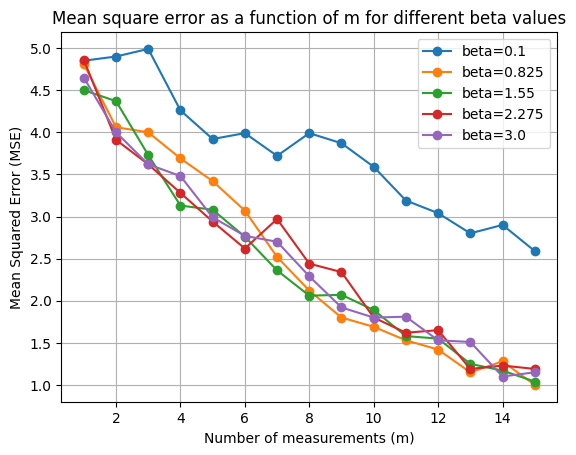

In [ ]:
for b in beta:
    plt.plot(ms, mse_results[b], marker='o', label=f'beta={b}')
plt.xlabel('Number of measurements (m)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean square error as a function of m for different beta values')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
d = 10  
ms = range(1, 16)
beta = 1.0
N = 1000 
M = 10000

In [106]:
mse_values = []  # Lista per memorizzare i valori dell'MSE per ogni beta
for m in ms:
    errors = []
    for _ in range(M):
        X, y, theta_true = generate_data(m, d)  # Genera i dati, theta_true è quello che sto cercando
        theta_init = np.random.randint(0, 2, d)  # Inizializza casualmente theta
        theta_est = metropolis_hastings(X, y, be, N, theta_init)  # Stima theta usando Metropolis-Hastings
        error = mean_squared_error(theta_true, theta_est)  # Calcola l'errore quadratico medio
        errors.append(error)  # Aggiungi l'errore alla lista degli errori
    mse = np.mean(errors)  # Calcola la media degli errori per il valore corrente di m
    mse_values.append(mse)  # Aggiungi l'MSE alla lista dei valori di MSE

In [ ]:
# Plot dei risultati
plt.plot(ms, mse_values, marker='o')
plt.xlabel('Numero di misurazioni (m)')
plt.ylabel('Errore quadratico medio (MSE)')
plt.title('Errore quadratico medio in funzione di m')
plt.grid(True)
plt.show()

In [107]:
# Determinare il valore minimo di m per cui l'MSE è sufficientemente basso
threshold_mse = 1.0  # Soglia arbitraria per considerare la stima affidabile
reliable_m_indices = [i for i, mse in enumerate(mse_values) if mse < threshold_mse]
if reliable_m_indices:
    min_m = ms[reliable_m_indices[0]]
    print(f"Valore minimo di m/d per recuperare theta in modo affidabile: {min_m/d:.2f}")
else:
    print("Non è stato trovato un valore di m per cui l'MSE è inferiore alla soglia.")

Valore minimo di m/d per recuperare theta in modo affidabile: 0.90
